In [1365]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np

from collections import defaultdict

import plotly.graph_objects as go
from plotly import express as px

import sys
sys.path.append('../src/sankey/')

from utils2 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PREPARATION

In [1366]:
INN_FEATURES = ['region', 'activity_field']
VEHICLE_FEATURES = ['vin', 'brand', 'chassis_config', 'year', 'body_type', 'model', 'age']
TRANSACTION_FEATURES = ['operation_date', 'operation_reason', 'operation_year']

############################################################################################

INN_INFO_PATH = '../data/processed/inn_info.parquet'

%time df = pd.read_parquet('../data/processed/gibdd.parquet')
df = df.drop('region', axis=1).rename({'Наименование':'region'}, axis=1)
df.loc[df['inn'].isna(), 'inn'] = df.loc[df['inn'].isna(), 'activity_field'] #replace nan with "физлицо"

inn_info = pd.read_parquet(INN_INFO_PATH)

# Добавляем upper_activity из ОКВЭД до первой точки
df_okved = pd.read_csv('/home/jovyan/remote_shared_data/dsdiag222/gibdd_dataset_raw/okved.csv', delimiter=';', error_bad_lines=False, warn_bad_lines=False)
okved_dict = df_okved.loc[df_okved['Code'].str.split('.').str.len() == 1 & df_okved['Code'].apply(lambda x: 'РАЗДЕЛ' not in x)].set_index('Code').to_dict()['Name']
okved_dict = defaultdict(str, okved_dict)
inn_info.loc[~inn_info['activity_code'].isna(), 'upper_activity'] = inn_info.loc[~inn_info['activity_code'].isna(), 'activity_code'].apply(lambda x: okved_dict[x.split('.')[0]])

del okved_dict, df_okved

%time transaction_data = prepare_date(df, inn_info, INN_FEATURES, VEHICLE_FEATURES, TRANSACTION_FEATURES)

CPU times: user 10.1 s, sys: 12.6 s, total: 22.7 s
Wall time: 11.8 s
CPU times: user 11.9 s, sys: 1.01 s, total: 12.9 s
Wall time: 12.9 s


# QUERY SELLER BUYER VEHICLE TRANSACTION

In [1367]:
SelectMultipleInteract(transaction_data, ['region_seller', 'activity_field_seller', 'brand', 'model', 'chassis_config'])

SelectMultipleInteract(children=(SelectMultiple(description='region_seller', options=(nan, 'Воронежская област…

### Атрибуты продавцов/покупателей (Группировка по этим атрибутам):
    - 'inn'
    - 'name'
    - 'group' - Холдинг
    - 'region'
    - 'acitivity_field' - Вид деятельности из ГИБДД
    - 'activity_code' - ОКВЭД из СПАРК
    - 'activity' - Вид деятельности из СПАРК
    - 'upper_activity' - ОКВЭД до первой точки в коде
    - 'status'
    - 'risk'
    - 'size'

### Атрибуты авто:
    - 'vin'
    - 'brand'
    - 'chassis_config'
    - 'year'
    - 'body_type'
    - 'model'
    - 'age'

### Атрибуты транзакций:
    - 'operation_date'
    - 'operation_reason'
    - 'operation_year'

In [1454]:
seller_select = {
  # 'region_seller':['Москва', 'Московская область'],
 #   'activity_field_seller': ['Нефтегазодобывающая'],
#     'region_seller':['Татарстан'],
    'inn_seller':['5027217553'],
  #  'size_seller':['Крупные предприятия']
  #  'name_seller':['ООО "ИТЕКО ТРАНСПОРТ"']
}

buyer_select = {
   # 'inn_buyer': ['1639049890'],
  #  'region_buyer':['Московская область'],
#    'activity_field_buyer': ['ФИЗ ЛИЦО'],
      #  'name_buyer':['ООО "ИТЕКО ТРАНСПОРТ"']
}

vehicle_select = {
 # 'brand': ['MERCEDES-BENZ'],
 #  'model': ['5490'],
#    'chassis_config': ['4x2'],
  #  'body_type':['Тягач седельный'],
   # 'year':[2013],
    
    
}

transaction_select = {    
  #  'operation_year':[2019],
   # 'operation_reason':['первичная регистрация']
}

seller_group = 'inn_seller'
buyer_group = 'name_buyer'

In [1455]:
tmp = dataframe_select(
    transaction_data, 
        [
            seller_select,
            buyer_select,
            vehicle_select,
            transaction_select
        ])

In [1456]:
tmp.shape[0]

0

In [1453]:
tmp['operation_reason'].value_counts()

Series([], Name: operation_reason, dtype: int64)

In [1427]:
#tmp['size_seller'].value_counts()

In [1428]:
#tmp['size_seller'].isna().sum()

In [1429]:
#tmp[tmp['activity_field_seller'] == 'ФИЗ ЛИЦО'].shape

In [1430]:
#tmp['size_buyer'].value_counts()

In [1431]:
#buf = tmp[tmp['size_buyer'].isna()]

In [1432]:
#buf[buf['inn_seller'].isna()]

In [1433]:
#display(tmp)

In [1434]:
tmp['body_type'].value_counts()

Тягач седельный    44
Name: body_type, dtype: int64

In [1435]:
tmp['name_seller'].value_counts()

ООО "М7 ТРАК"    44
Name: name_seller, dtype: int64

In [1436]:
tmp['brand'].value_counts()

SCANIA           36
MERCEDES-BENZ     6
КАМАЗ             1
VOLVO             1
Name: brand, dtype: int64

In [1437]:
tmp['operation_year'].value_counts()

2019    44
Name: operation_year, dtype: int64

In [1438]:
tmp['year'].value_counts()

2011.0    8
2008.0    7
2016.0    7
2017.0    7
2014.0    5
2013.0    4
2010.0    2
2012.0    2
2015.0    2
Name: year, dtype: int64

In [1439]:
tmp['inn_seller'].value_counts()

1639049890    44
Name: inn_seller, dtype: int64

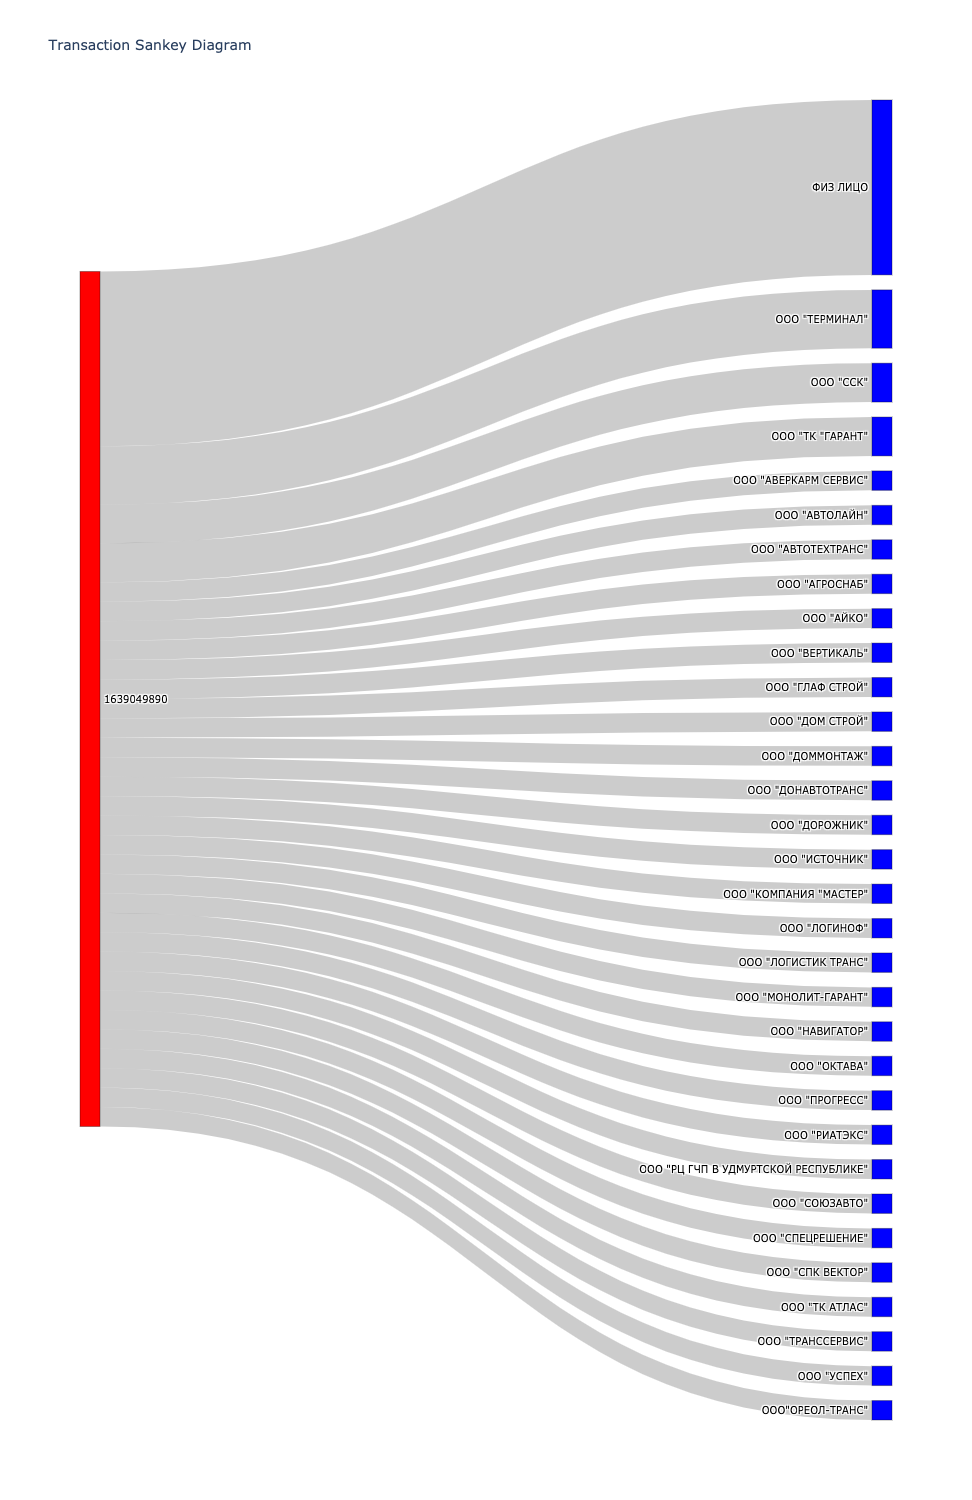

In [1440]:
sankey(
    tmp,
    seller=seller_group,
    buyer=buyer_group,
    bipartite=True,
    display_nan=True,
    display_minor=False,
    drop_cycle=True,
   #min_transaction_seller=10,
    #min_transaction_buyer=10,
)

In [1402]:
#get_histogram(tmp, sec_feature='region_seller')
get_transacation_count(tmp, 'operation_year', 'year')

year,2004.0,2008.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
operation_year,,,,,,,,,,
2019,1,10,2,4,1,4,20,2,12,14
